<a href="https://colab.research.google.com/github/MMathisLab/Nx-435_EPFL/blob/main/Notebooks/Demo_PSTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Calculating a Peri-Stimulus Time Histogram (PSTH):

For NX-435 by Mackenzie Mathis

### What is a PSTH?

It's a common tool used in neuroscience to analyze the firing patterns of neurons in response to a stimulus.

The Peri-Stimulus Time Histogram (PSTH) plots the average firing rate of a neuron over time relative to the onset of a stimulus. Here's how it's typically calculated:

1. Define a time window around the onset of the stimulus.
2. Divide this time window into small bins.
3. Count the number of spikes (action potentials) that occur within each bin across multiple trials.
4. Average the spike counts across trials for each bin.
5. Plot the average spike count (firing rate) for each bin as a function of time.

The PSTH provides insights into the temporal dynamics of neuronal responses to a stimulus. It's commonly used to study sensory processing, motor control, and other aspects of neural coding. By analyzing the PSTH, researchers can infer how neurons encode information about stimuli and how their firing rates change over time in response to different experimental conditions.

It also allows you to both visulaize AND quantify neural spiking consistency across trials!

- This notebook uses mostly standard python libraries, with the addition of the tdt package to grab some demo data (thanks!)

In [1]:
pip install tdt

In [2]:
#%config InlineBackend.close_figures = False
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tdt

Demo code/data from here: https://www.tdt.com/docs/sdk/offline-data-analysis/offline-data-python/examples/03_RasterPSTH/#housekeeping

In [3]:
tdt.download_demo_data()
BLOCK_PATH = 'data/Algernon-180308-130351'

demo data ready


### There are 16 channels on this recording array; therefore you can look at any channel for computing a PSTH

- the assumption is each channel here is an undividual unit (neuron), which is extracted after spike sorting.

- if you want to look at other channels, just change the cell below and re-run the cells below it.

In [4]:
CHANNEL = 3 #3 is default

In [5]:
REF_EPOC = 'PC0/'
SNIP_STORE = 'eNe1'
SORTID = 'TankSort'
SORTCODE = 0          # set to 0 to use all sorts
TRANGE = [-0.3, 0.8]
data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)


#Next we will do a bit of preprocessing; Using the `t` parameter extracts data only from the time range around the defined epoc event.
raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
#Adding the `tref` flag takes the timestamps relative to the epoc event:
hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')

num_trials = raster_data.time_ranges.shape[1]

read from t=0s to t=61.23s


## Okay, data loading and a bit of pre-processing is done!

- now we will start making some plots and explore the data!
- Let's plot the spikes in bins across time for all the trials (combined):

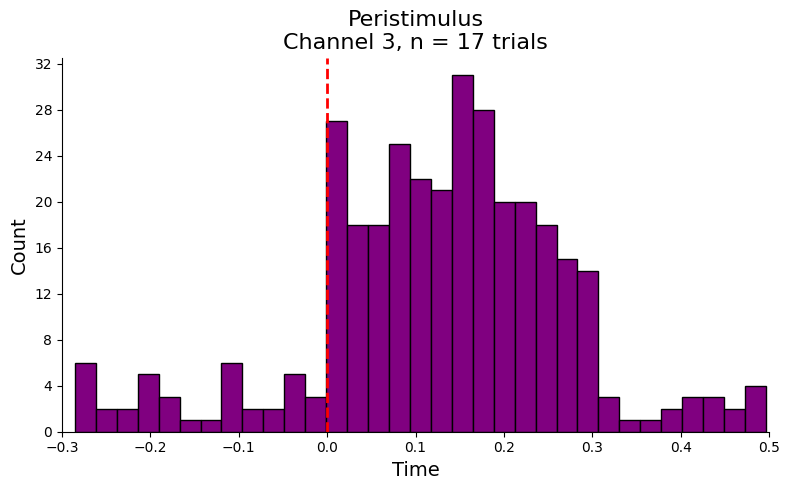

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts) / 10.))
hist_n, bins, _ = ax.hist(hist_ts, nbins, color='purple', edgecolor='black')

ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0.
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

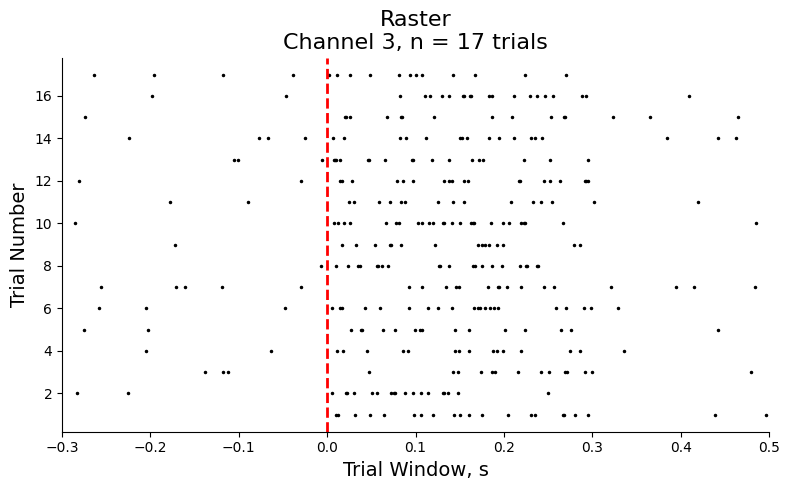

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

# For the raster plot
all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax.plot(all_x, all_y, 'k.', markersize=3)
ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax.set_xlabel('Trial Window, s', fontsize=14)
ax.set_ylabel('Trial Number', fontsize=14)
ax.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0.
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis.
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## If you want to plot them together:

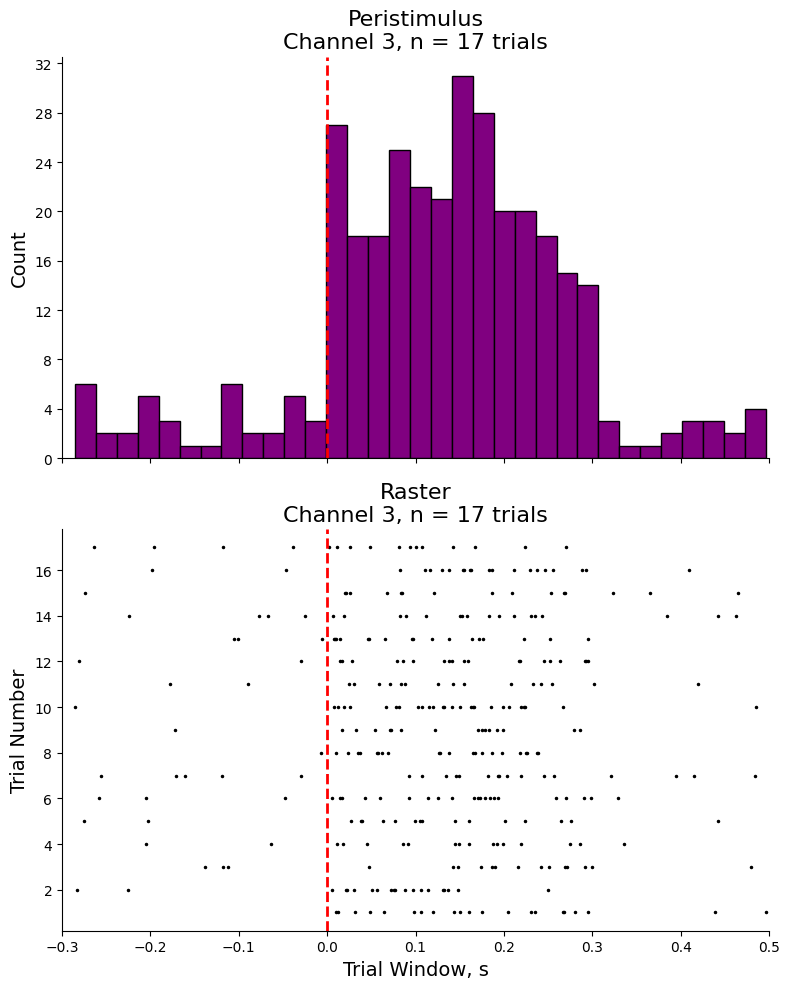

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot histogram (counts)
hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts) / 10.))
hist_n, bins, _ = ax1.hist(hist_ts, nbins, color='purple', edgecolor='black')

ax1.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0 for histogram
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis for histogram
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines for histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# For the raster plot
all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax2.plot(all_x, all_y, 'k.', markersize=3)
ax2.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax2.set_xlabel('Trial Window, s', fontsize=14)
ax2.set_ylabel('Trial Number', fontsize=14)
ax2.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0 for raster
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis for raster
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines for raster
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Let's examine the standard deviation across trials

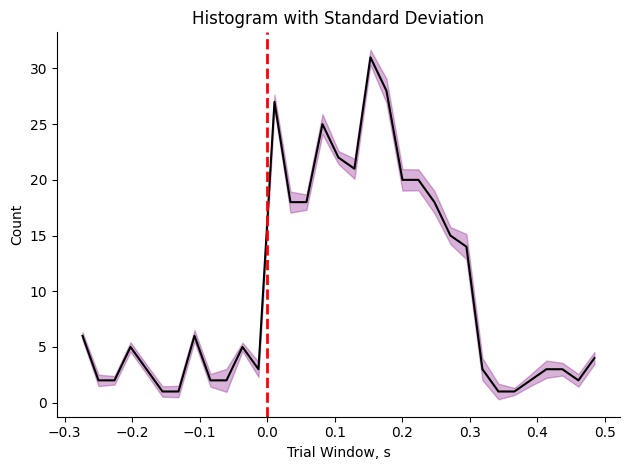

In [9]:
# Compute standard deviation per time bin
bin_stds = []
for i in range(nbins):
    bin_values = []
    for trial in range(num_trials):
        trial_ts = all_ts[trial]
        counts, bin_edges = np.histogram(trial_ts, bins=nbins)
        bin_values.append(counts[i])
    bin_stds.append(np.std(bin_values))

bin_stds = np.array(bin_stds)

# Plot mean plus standard deviation
bin_centers = (bins[:-1] + bins[1:]) / 2

# Connect the dots
plt.plot(bin_centers, hist_n, color='black')

# Shade the error bars
plt.fill_between(bin_centers, hist_n - bin_stds, hist_n + bin_stds, color='purple', alpha=0.3)

# Draw a vertical line at t=0 for histogram
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Trial Window, s')
plt.ylabel('Count')
plt.title('Histogram with Standard Deviation')
plt.tight_layout()
plt.show()

## Alright, so lets just flag when the count (firing) in a given bin is > the mean+/-STD firing during the baseline period (before stimulus onset):

Mean count rate in baseline:  3.0 +/- 7.0


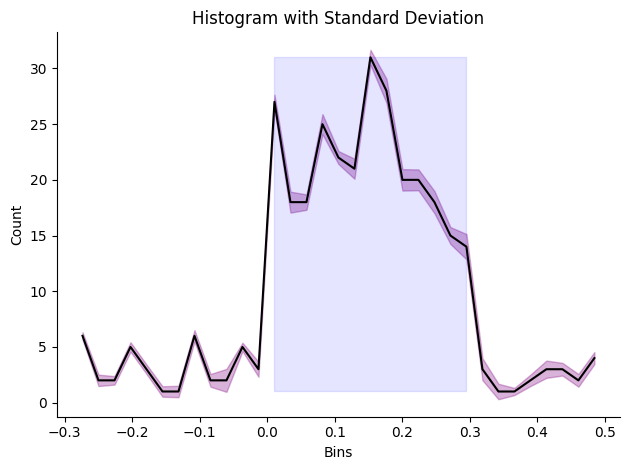

In [10]:
#NOTE:
#bins is the time axis
#hist_n is the count

# Compute mean firing rate before stimulus onset (i.e, what is the mean count before time 0?)
mean_firing_rate_before_stimulus = np.mean(hist_n[bins[1:] < 0])
std_firing_rate_before_stimulus = np.std(hist_n[bins[:-1] < 0])
print("Mean count rate in baseline: ", np.round(mean_firing_rate_before_stimulus), "+/-",np.round(std_firing_rate_before_stimulus))


# Compare each bin count to the mean firing rate before stimulus onset plus/minus one standard deviation
flag = np.logical_and(hist_n > (mean_firing_rate_before_stimulus + std_firing_rate_before_stimulus),
                              hist_n > (mean_firing_rate_before_stimulus - std_firing_rate_before_stimulus))

# Plot mean plus standard deviation
bin_centers = (bins[:-1] + bins[1:]) / 2

# Connect the dots
plt.plot(bin_centers, hist_n, color='black')

# Shade the error bars
plt.fill_between(bin_centers, hist_n - bin_stds, hist_n + bin_stds, color='purple', alpha=0.3)

# Highlight bins with significant difference
plt.fill_between(bin_centers, np.min(hist_n), np.max(hist_n), where=flag, color='blue', alpha=0.1)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Histogram with Standard Deviation')
plt.tight_layout()
plt.show()


# Lastly, lets look at all the data together

- bonus: can you then plot the mean count for each CHANNEL?

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


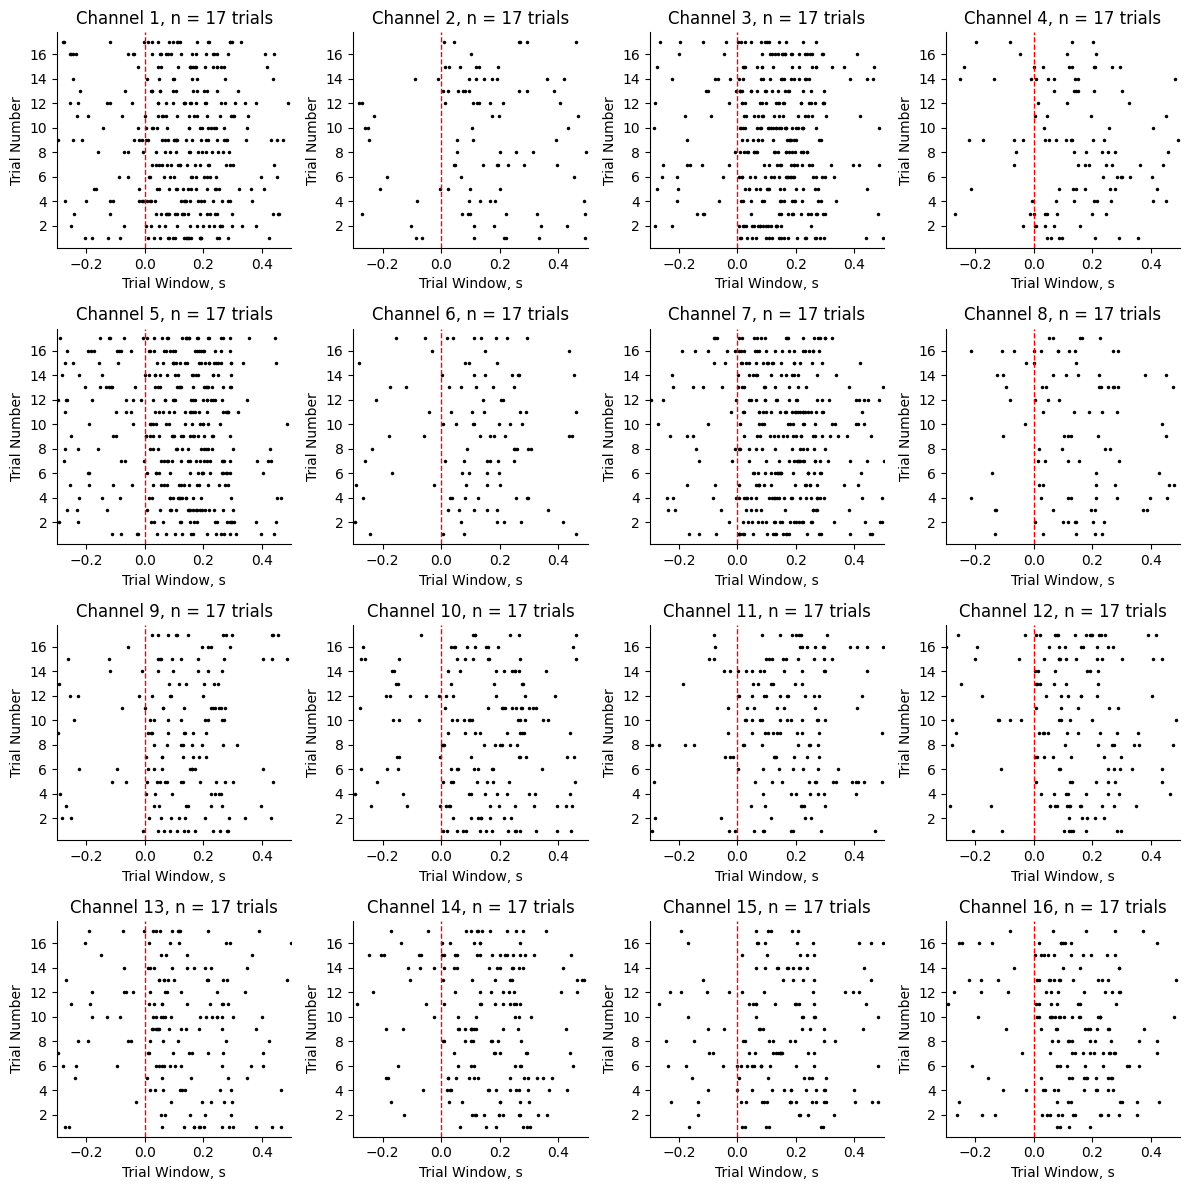

In [11]:
def plot_raster_subplot(ax, raster_data, TRANGE, CHANNEL):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)

    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')

    num_trials = raster_data.time_ranges.shape[1]

    # For the raster plot
    all_ts = [[] for x in range(num_trials)]
    all_y = [[] for x in range(num_trials)]
    for trial in range(num_trials):
        trial_on = raster_data.time_ranges[0, trial]
        trial_off = raster_data.time_ranges[1, trial]
        ind1 = ts >= trial_on
        ind2 = ts < trial_off
        trial_ts = ts[ind1 & ind2]
        all_ts[trial] = trial_ts - trial_on + TRANGE[0]
        all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

    all_x = np.concatenate(all_ts)
    all_y = np.concatenate(all_y)

    # Make the raster plot.
    ax.plot(all_x, all_y, 'k.', markersize=3)
    ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
    ax.set_xlabel('Trial Window, s', fontsize=10)
    ax.set_ylabel('Trial Number', fontsize=10)
    ax.set_title('Channel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=12)

    # Draw a vertical line at t=0.
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # Set integer ticks on y-axis.
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Remove top and right spines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Iterate over rows and columns to plot each subplot
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        # Calculate the current channel based on the loop indices
        CHANNEL = i * 4 + j + 1
        plot_raster_subplot(ax, raster_data, TRANGE, CHANNEL)

plt.tight_layout()
plt.show()



# BONUS: clustering the cells by their PSTH signature
- here we will use PCA with k-means clustering to cluster into 3 groups (you can test if more or less is best!)
- color by cluster ID

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


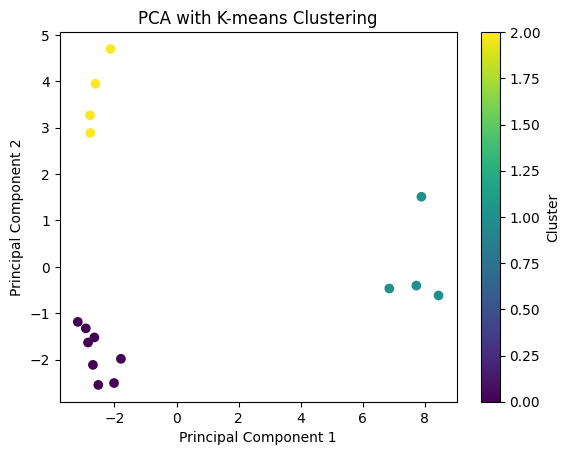

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def read_data_for_channel(channel):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=channel, nodata=1)
    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)
    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')
    num_trials = raster_data.time_ranges.shape[1]
    # Calculate PSTH data
    hist_ts = hist_data.snips[SNIP_STORE].ts
    nbins = np.int64(np.floor(len(hist_ts) / 10.))
    hist_n, _ = np.histogram(hist_ts, nbins)
    return hist_n


# Read PSTH data for each channel and store in a list
psth_data = []
max_nbins = 0  # Track the maximum number of bins among all channels
for channel in range(1, 17):  # Assuming there are 16 channels
    hist_n = read_data_for_channel(channel)
    psth_data.append(hist_n)
    max_nbins = max(max_nbins, len(hist_n))

# Pad or truncate the PSTH data to ensure consistent shape
for i in range(len(psth_data)):
    psth_data[i] = np.pad(psth_data[i], (0, max_nbins - len(psth_data[i])), mode='constant', constant_values=0)

# Convert the list of PSTH data into a numpy array
psth_data = np.array(psth_data)

# Preprocess the data (standardize it)
scaler = StandardScaler()
scaled_psth_data = scaler.fit_transform(psth_data)

# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(scaled_psth_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(pca_result)

# Visualize the clusters (optional)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()



## Color by channel ID:
- this assumes you have run the cell above

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


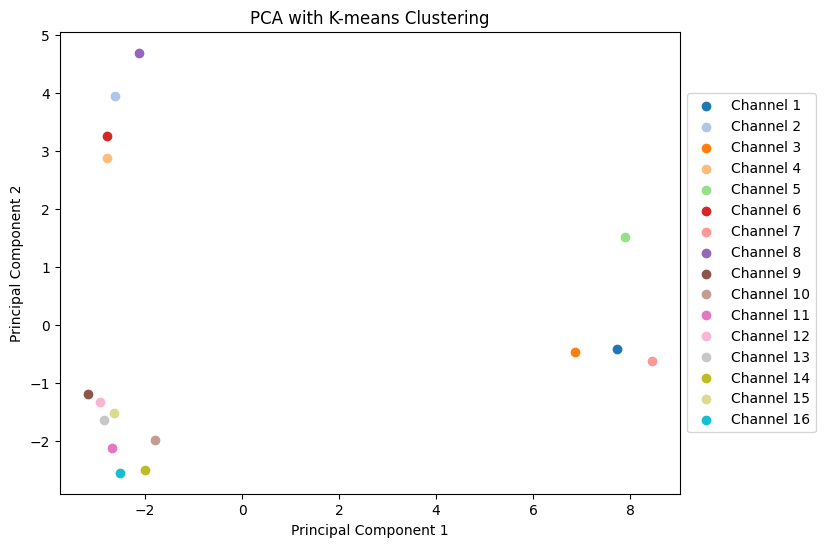

In [13]:
from matplotlib.lines import Line2D

# Read PSTH data for each channel and store in a list
psth_data = []
channel_ids = []  # Store channel IDs
max_nbins = 0  # Track the maximum number of bins among all channels
for channel in range(1, 17):  # Assuming there are 16 channels
    hist_n = read_data_for_channel(channel)
    psth_data.append(hist_n)
    channel_ids.append(channel)
    max_nbins = max(max_nbins, len(hist_n))

# Pad or truncate the PSTH data to ensure consistent shape
for i in range(len(psth_data)):
    psth_data[i] = np.pad(psth_data[i], (0, max_nbins - len(psth_data[i])), mode='constant', constant_values=0)

# Convert the list of PSTH data into a numpy array
psth_data = np.array(psth_data)

# Standardize the data
scaler = StandardScaler()
scaled_psth_data = scaler.fit_transform(psth_data)



# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(scaled_psth_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(pca_result)

# Visualize the clusters with colored dots and add a legend
plt.figure(figsize=(8, 6))
legend_elements = []
for i, channel_id in enumerate(channel_ids):
    color = plt.cm.tab20(i / len(channel_ids))
    plt.scatter(pca_result[channel_id - 1, 0], pca_result[channel_id - 1, 1], color=color, label='Channel {}'.format(channel_id))
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Channel {}'.format(channel_id), markerfacecolor=color, markersize=8))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with K-means Clustering')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Do these clusters make sense? Let's inspect them.

- you can iteratively change the channels to plot based on the clustering above ^ !

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


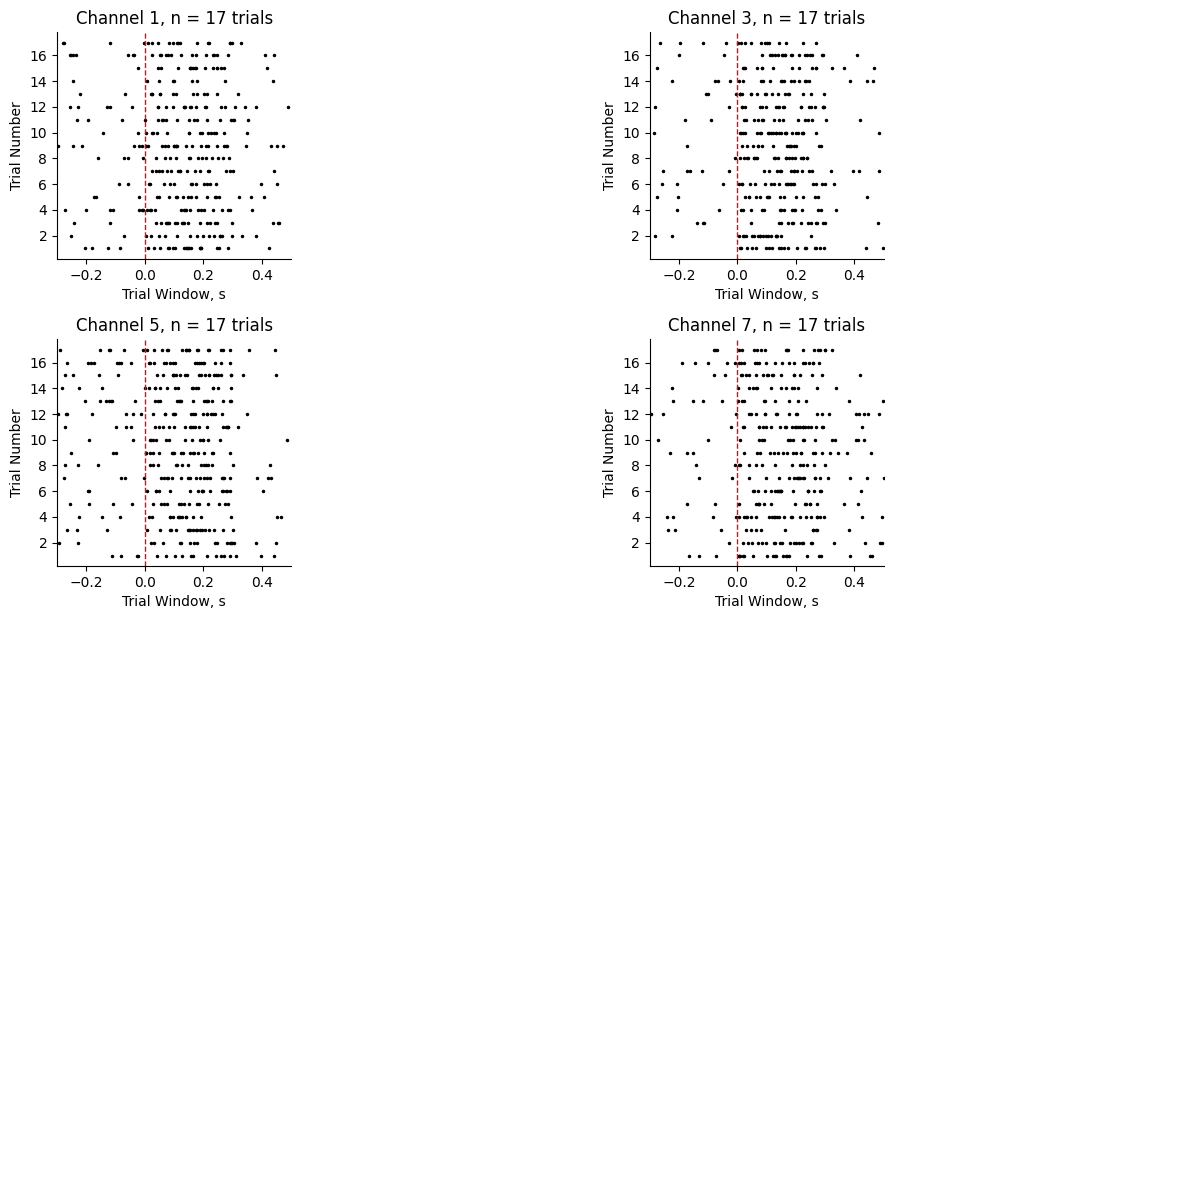

In [14]:
# List of channels to plot:

channels_to_plot = [1, 3, 7, 5]
#channels_to_plot = [4, 6, 2, 8]
#channels_to_plot = [16, 15, 14, 13, 12, 10, 9]

def plot_cluster_subplot(ax, raster_data, TRANGE, CHANNEL):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)

    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')

    num_trials = raster_data.time_ranges.shape[1]

    # For the raster plot
    all_ts = [[] for x in range(num_trials)]
    all_y = [[] for x in range(num_trials)]
    for trial in range(num_trials):
        trial_on = raster_data.time_ranges[0, trial]
        trial_off = raster_data.time_ranges[1, trial]
        ind1 = ts >= trial_on
        ind2 = ts < trial_off
        trial_ts = ts[ind1 & ind2]
        all_ts[trial] = trial_ts - trial_on + TRANGE[0]
        all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

    all_x = np.concatenate(all_ts)
    all_y = np.concatenate(all_y)

    # Make the raster plot.
    ax.plot(all_x, all_y, 'k.', markersize=3)
    ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
    ax.set_xlabel('Trial Window, s', fontsize=10)
    ax.set_ylabel('Trial Number', fontsize=10)
    ax.set_title('Channel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=12)

    # Draw a vertical line at t=0.
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # Set integer ticks on y-axis.
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Remove top and right spines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))



# Iterate over rows and columns to plot each subplot
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        # Calculate the current channel based on the loop indices
        CHANNEL = i * 4 + j + 1
        if CHANNEL in channels_to_plot:
            plot_cluster_subplot(ax, raster_data, TRANGE, CHANNEL)
        else:
            ax.axis('off')  # Turn off the axes for channels not to be plotted

plt.tight_layout()
plt.show()